In [1]:
from IPython.display import HTML
HTML(open('../style.css').read())

In [2]:
%load_ext nb_mypy

Version 1.0.6


# An EBNF based Parser for Arithmetic Expressions

In this notebook we implement an <span style="font-variant:small-caps;">Ebnf</span> recursive-descend parser for arithmetic expressions.  This parser implements the following <span style="font-variant:small-caps;">Ebnf</span> grammar:
$$
  \begin{eqnarray*}
  \mathrm{expr}    & \rightarrow & \mathrm{product}\;\;\bigl((\texttt{'+'}\;|\;\texttt{'-'})\;\; \mathrm{product}\bigr)^* \\[0.2cm]
  \mathrm{product} & \rightarrow & \mathrm{factor} \;\;\bigl((\texttt{'*'}\;|\;\texttt{'/'})\;\; \mathrm{factor}\bigr)^*  \\[0.2cm]   
  \mathrm{factor}  & \rightarrow & \texttt{'('} \;\;\mathrm{expr} \;\;\texttt{')'}                             \\
                   & \mid        & \texttt{NUMBER} 
  \end{eqnarray*}
$$

## The Scanner

In [3]:
import re

The function `tokenize` receives a string `s` as argument and returns a list of tokens.
The string `s` is supposed to represent an arithmetical expression. 

**Note:** 
 - We need to set the flag `re.VERBOSE` in our call of the function `findall`
   below because otherwise we are not able to format the regular expression `lexSpec` the way 
   we have done it.  Furthermore, we wouldn't have been able to add comments inside the regular expression.
 - Since the regular expression does not allow white space, `tokenList` will contain lots of 
   empty strings.  These have to be removed.

In [4]:
def tokenize(s: str) -> list[str]:
    lexSpec = r'''[a-z][0-9]*   |  # variables
                  [1-9][0-9]*|0 |  # numbers
                  [-+*/()]      |  # arithmetical operators and parentheses
               '''
    tokenList = re.findall(lexSpec, s, re.VERBOSE)
    return [t for t in tokenList if t != '']

In [5]:
print(tokenize('12 * x + y1 * 4 / 6 - z3'))

['12', '*', 'x', '+', 'y1', '*', '4', '/', '6', '-', 'z3']


## Implementing the Recursive Descend Parser

The type `AST` represents an *abstract syntax tree*. 

In [6]:
from typing import TypeVar
from typing import Literal

In [7]:
type BinaryOp = Literal['+', '-', '*', '/']
AST = TypeVar('AST')
AST = int | str | tuple[BinaryOp, AST, AST]

Since the functions `parseExpr`, `parseProduct`, and `parseFactor` are mutually recursive,
we need to declare their types in a forward declaration.

In [8]:
def parseExpr(TL: list[str]) -> tuple[AST, list[str]]:
    return None # type: ignore

def parseProduct(TL: list[str]) -> tuple[AST, list[str]]:
    return None # type: ignore

def parseFactor(TL: list[str]) -> tuple[AST, list[str]]:
    return None # type: ignore

The function `parse` takes a string `s` as input and parses this string according to the recursive grammar
shown above.

In [9]:
def parse(s: str) -> AST:
    TL           = tokenize(s)
    result, Rest = parseExpr(TL)
    assert Rest == [], f'Parse Error: could not parse {TL}, Rest = {Rest}'
    return result

The function `parseExpr(TL)` takes a list of tokens `TL` and tries to parse an expresssion according to the following
<span style="font-variant:small-caps;">Ebnf</span> grammar rule:
$$ \mathrm{expr} \;\rightarrow\; \mathrm{product}\;\;\bigl((\texttt{'+'}\;|\;\texttt{'-'})\;\; \mathrm{product}\bigr)^* $$
It returns an *abstract syntax tree* representing the expression and a list of all the tokens that have not been consumed during parsing.

In [10]:
def parseExpr(TL: list[str]) -> tuple[AST, list[str]]:
    result, Rest = parseProduct(TL)
    while len(Rest) >= 2 and Rest[0] in {'+', '-'}: 
        operator  = Rest[0]
        arg, Rest = parseProduct(Rest[1:])
        result    = (operator, result, arg)
    return result, Rest

Error in type checker, you can turn it off with '%nb_mypy Off'


In [11]:
%nb_mypy Off

The function `parseProduct(TL)` takes a list of tokens `TL` and tries to parse a product according to the following
<span style="font-variant:small-caps;">Ebnf</span> grammar rule:
$$ \mathrm{product} \;\rightarrow\; \mathrm{factor} \;\;\bigl((\texttt{'*'}\;|\;\texttt{'/'})\;\; \mathrm{factor}\bigr)^*  $$
It returns the value of the product and a list of all the tokens that have not been consumed during parsing.

In [12]:
def parseProduct(TL: list[str]) -> tuple[AST, list[str]]:
    result, Rest = parseFactor(TL)
    while len(Rest) >= 2 and Rest[0] in {'*', '/'}:
        operator   = Rest[0]
        arg, Rest  = parseFactor(Rest[1:])
        result     = (operator, result, arg)
    return result, Rest

The function `parseFactor` implements the following grammar rules:
$$
  \begin{eqnarray*}
  \mathrm{factor}      & \;\rightarrow\; & \texttt{'('} \;\;\mathrm{expr} \;\;\texttt{')'}    \\
                       & \;\mid          & \;\texttt{NUMBER}                                  \\
                       & \;\mid          & \;\texttt{VARIABLE}
  \end{eqnarray*}
$$

It takes one argument:
- `TL` is the list of tokens that still need to be consumed.

It returns a pair of the form `(value, Rest)` where
- `value` is the result of evaluating the arithmetical expression
  that is represented by `TL` and
- `Rest` is a list of those tokens that have not been consumed while trying to parse a factor.

In [13]:
def parseFactor(TL: list[str]) -> tuple[AST, list[str]]:
    if TL[0] == '(': 
        expr, Rest = parseExpr(TL[1:])
        assert Rest[0] == ')', "ERROR: ')' expected, got {Rest[0]}"
        return expr, Rest[1:]
    elif TL[0][0] in { str(d) for d in range(10) }:
        return int(TL[0]), TL[1:]
    else: 
        return TL[0], TL[1:]

## Testing

In [14]:
import graphviz as gv

In [15]:
%run AST2Dot.ipynb

In [17]:
def test(s: str) -> float:
    tree = parse(s)
    return tuple2dot(tree)

In [18]:
parse('12 * y * x + 14 * z / 6 - x')

('-', ('+', ('*', ('*', 12, 'y'), 'x'), ('/', ('*', 14, 'z'), 6)), 'x')

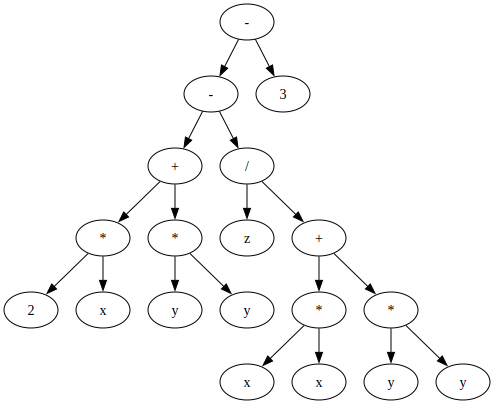

In [19]:
test('2 * x + y * y - z / (x * x + y * y) - 3')